# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
import splitfolders
import PIL
import glob
import cv2
import time
from sklearn.metrics import confusion_matrix, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import sys
import shutil
import glob as gb
import pickle
from sklearn.svm import SVC

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split

# Importing Dataset

In [4]:
# class config:
    
#     data_path = 'Dataset/'
    
#     path_train = "./output/train"
#     path_test = "./output/test"

In [5]:
# splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.8, .2))

# CNN

In [6]:
BATCH_SIZE = 128
IMAGE_SHAPE = (224, 224)

In [7]:
TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 47658 images belonging to 15 classes.
Found 11919 images belonging to 15 classes.


In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [10]:
model = Sequential()
model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(384, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy',f1_score,recall_m,precision_m])
history = model.fit(train_gen, validation_data=val_gen, epochs=15, steps_per_epoch=len(train_gen), validation_steps=len(val_gen))

Epoch 1/15
373/373 [==============================] - 90s 235ms/step - loss: 1.2770 - accuracy: 0.4479 - f1_score: 0.3913 - recall_m: 0.2958 - precision_m: 0.6408 - val_loss: 0.8707 - val_accuracy: 0.5877 - val_f1_score: 0.5792 - val_recall_m: 0.4648 - val_precision_m: 0.7708
Epoch 2/15
373/373 [==============================] - 87s 234ms/step - loss: 0.7273 - accuracy: 0.6556 - f1_score: 0.6447 - recall_m: 0.5685 - precision_m: 0.7565 - val_loss: 0.5368 - val_accuracy: 0.7308 - val_f1_score: 0.7265 - val_recall_m: 0.7044 - val_precision_m: 0.7501
Epoch 3/15
373/373 [==============================] - 87s 234ms/step - loss: 0.5000 - accuracy: 0.7619 - f1_score: 0.7588 - recall_m: 0.7411 - precision_m: 0.7775 - val_loss: 0.4460 - val_accuracy: 0.7923 - val_f1_score: 0.7901 - val_recall_m: 0.7754 - val_precision_m: 0.8054
Epoch 4/15
373/373 [==============================] - 88s 237ms/step - loss: 0.4057 - accuracy: 0.8139 - f1_score: 0.8125 - recall_m: 0.8014 - precision_m: 0.8240 - val_

In [12]:
model.save('model/cnn.h5')

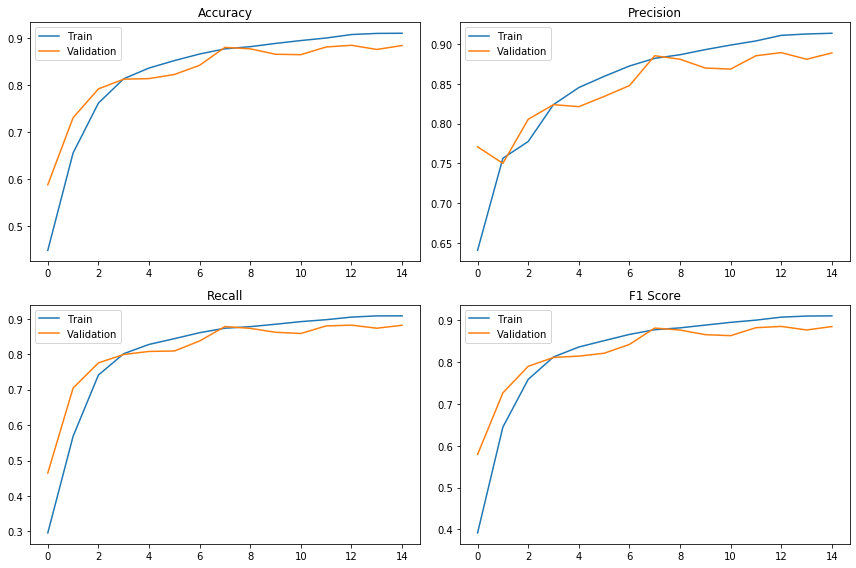

In [13]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']

# Create a figure and subplot for each metric
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [14]:
a1 = history.history['accuracy'][-1]
f1 = history.history['f1_score'][-1]
p1 = history.history['precision_m'][-1]
r1 = history.history['recall_m'][-1]

In [15]:
print('Accuracy = ' + str(a1))
print('Precision = ' + str(p1))
print('F1 Score = ' + str(f1))
print('Recall = ' + str(r1))

Accuracy = 0.9109698534011841
Precision = 0.9135406017303467
F1 Score = 0.9108045101165771
Recall = 0.9081100821495056


# Xception

In [16]:
BATCH_SIZE = 64
IMAGE_SHAPE = (224, 224)

TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Found 47658 images belonging to 15 classes.
Found 11919 images belonging to 15 classes.


In [17]:
inc = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(15, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy',f1_score,recall_m,precision_m])
history = model.fit(train_gen, validation_data=val_gen, epochs=15, steps_per_epoch=len(train_gen), validation_steps=len(val_gen))

Epoch 1/15
745/745 [==============================] - 219s 290ms/step - loss: 0.2201 - accuracy: 0.9168 - f1_score: 0.9152 - recall_m: 0.9102 - precision_m: 0.9214 - val_loss: 0.4645 - val_accuracy: 0.8890 - val_f1_score: 0.8887 - val_recall_m: 0.8839 - val_precision_m: 0.8936
Epoch 2/15
745/745 [==============================] - 212s 284ms/step - loss: 0.0858 - accuracy: 0.9703 - f1_score: 0.9702 - recall_m: 0.9689 - precision_m: 0.9714 - val_loss: 0.1225 - val_accuracy: 0.9552 - val_f1_score: 0.9555 - val_recall_m: 0.9542 - val_precision_m: 0.9569
Epoch 3/15
745/745 [==============================] - 215s 289ms/step - loss: 0.0657 - accuracy: 0.9782 - f1_score: 0.9783 - recall_m: 0.9775 - precision_m: 0.9790 - val_loss: 0.1361 - val_accuracy: 0.9652 - val_f1_score: 0.9654 - val_recall_m: 0.9647 - val_precision_m: 0.9660
Epoch 4/15
745/745 [==============================] - 212s 285ms/step - loss: 0.0514 - accuracy: 0.9833 - f1_score: 0.9832 - recall_m: 0.9826 - precision_m: 0.9837 - 

In [19]:
model.save('model/Xception.h5')

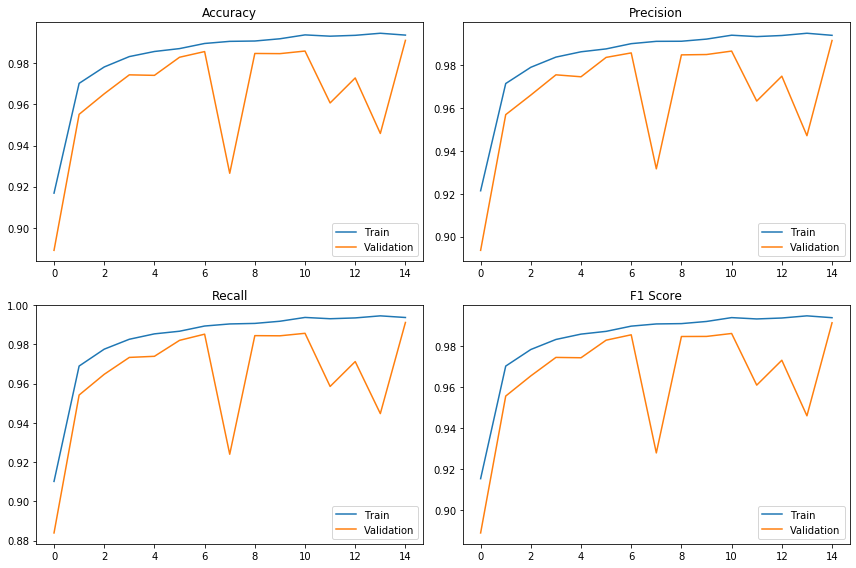

In [20]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']

# Create a figure and subplot for each metric
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [21]:
a2 = history.history['accuracy'][-1]
f2 = history.history['f1_score'][-1]
p2 = history.history['precision_m'][-1]
r2 = history.history['recall_m'][-1]


print('Accuracy = ' + str(a2))
print('Precision = ' + str(p2))
print('F1 Score = ' + str(f2))
print('Recall = ' + str(r2))

Accuracy = 0.9937471151351929
Precision = 0.9938842058181763
F1 Score = 0.9937793016433716
Recall = 0.9936761260032654


# Comparison

In [22]:
results ={'Accuracy': [a1,a2],
 'Recall':[r1,r2],
 'Precision': [p1,p2],
    'F1' : [f1,f2]}
index = ['CNN','Xception']

In [23]:
results =pd.DataFrame(results,index=index)
print(results)

          Accuracy    Recall  Precision        F1
CNN       0.910970  0.908110   0.913541  0.910805
Xception  0.993747  0.993676   0.993884  0.993779


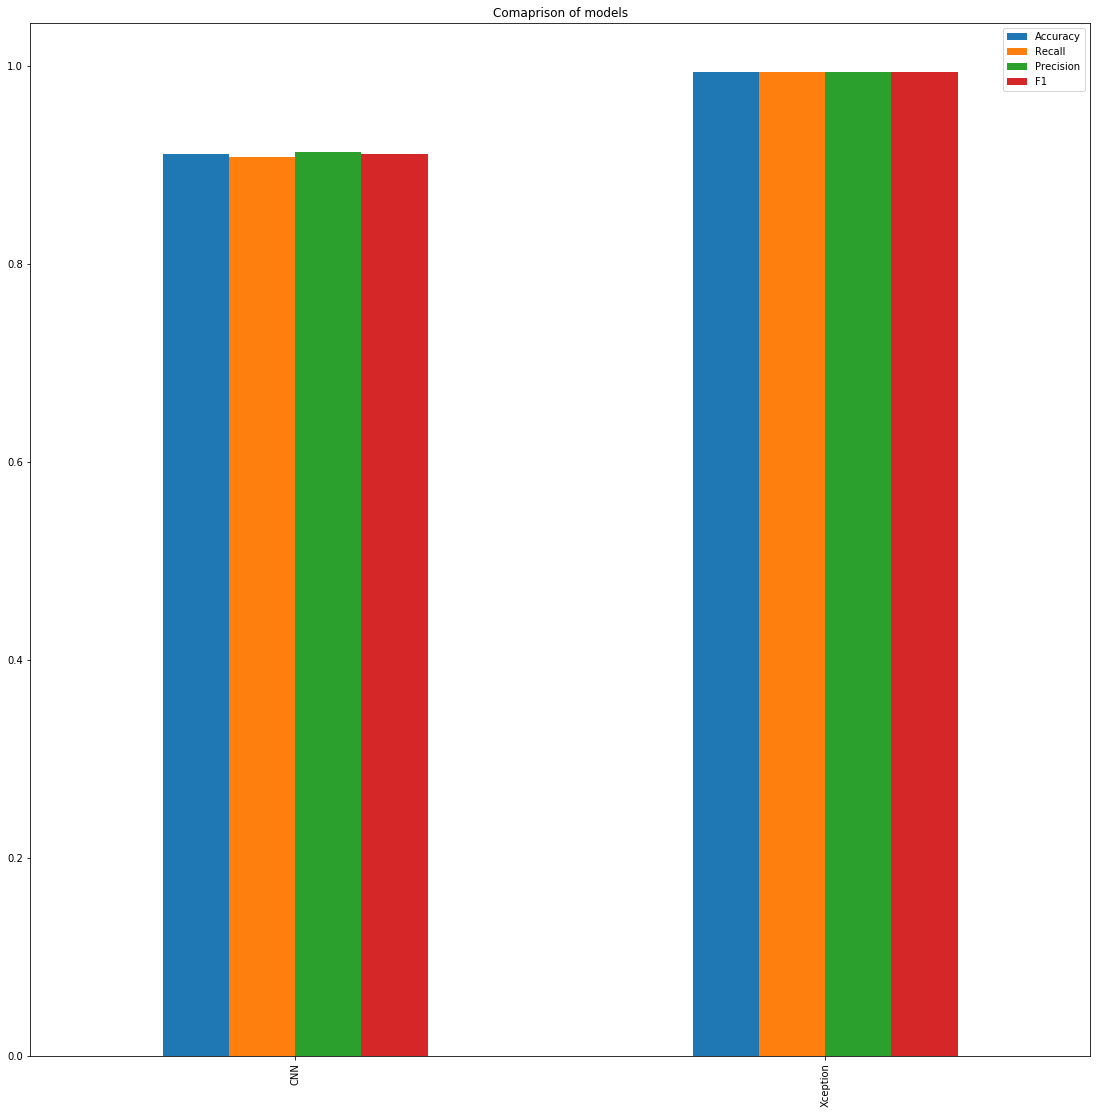

In [24]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002225F4DB648>,
      dtype=object)

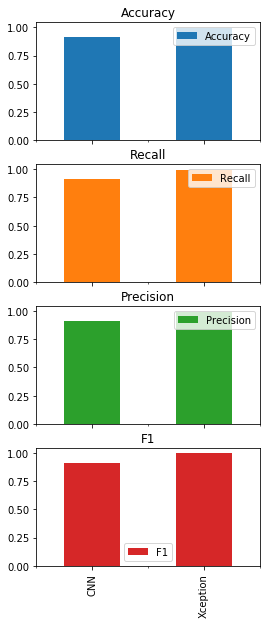

In [25]:
results.plot(subplots=True,kind ='bar',figsize=(4,10))

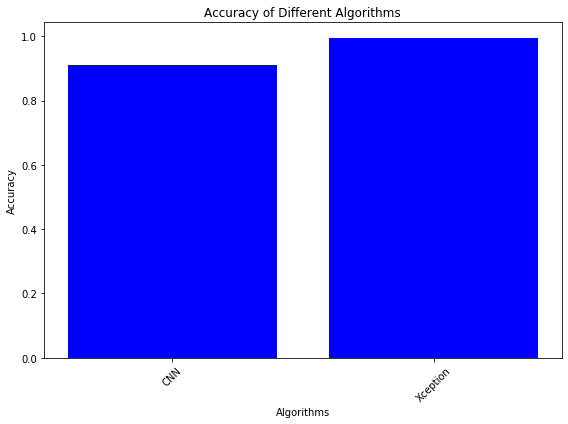

In [26]:

accuracy_values = results['Accuracy']
accuracy_df = pd.DataFrame({'Algorithms': index, 'Accuracy': accuracy_values})

plt.figure(figsize=(8, 6))
plt.bar(accuracy_df['Algorithms'], accuracy_df['Accuracy'], color='blue')
plt.title('Accuracy of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

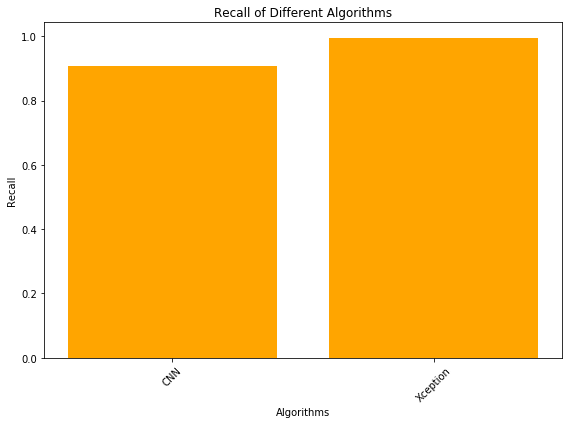

In [27]:
recall_values = results['Recall']
recall_df = pd.DataFrame({'Algorithms': index, 'Recall': recall_values})

plt.figure(figsize=(8, 6))
plt.bar(recall_df['Algorithms'], recall_df['Recall'], color='orange')
plt.title('Recall of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

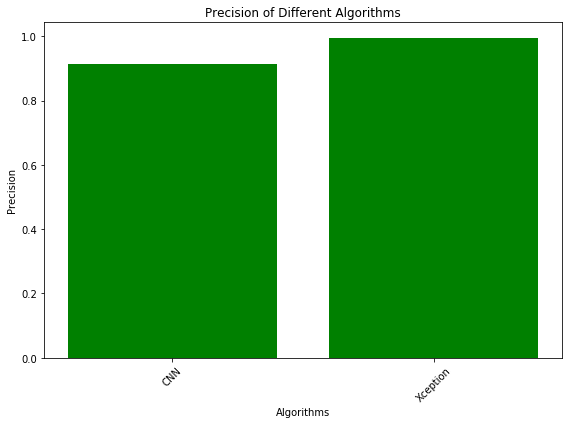

In [28]:
precision_values = results['Precision']
precision_df = pd.DataFrame({'Algorithms': index, 'Precision': precision_values})

plt.figure(figsize=(8, 6))
plt.bar(precision_df['Algorithms'], precision_df['Precision'], color='green')
plt.title('Precision of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

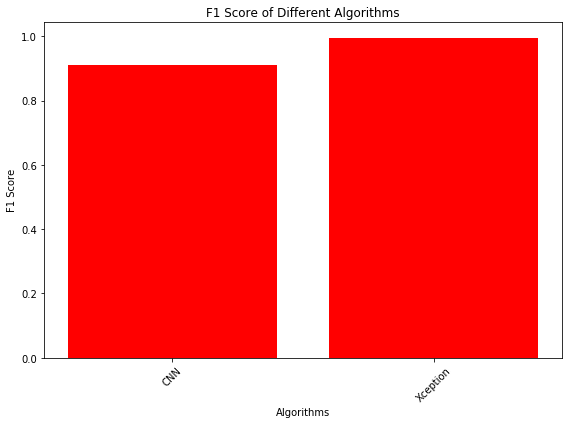

In [29]:
f1_values = results['F1']
f1_df = pd.DataFrame({'Algorithms': index, 'F1 Score': f1_values})

plt.figure(figsize=(8, 6))
plt.bar(f1_df['Algorithms'], f1_df['F1 Score'], color='red')
plt.title('F1 Score of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()